# Set params + import functions

In [3]:
from Utilities.alignment_functions import *

#'seq006_1_3'
mir = 'seq006_1_1'

probeA_shanks = [0,0,1,0]   # 1 == used, 0 == not used
probeB_shanks = [1,1,1,1]   # 1 == used, 0 == not used



# Choose data to process:

In [6]:

#sample rate:
Fs = 30000.0

## gather all raw ephys paths
path_ = r"Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\"
base_recording_paths = []
for q in os.listdir(path_):
    if not 'other_sessions' in q:
        if not 'sp5_recordings' in q:
            folder = os.path.join(path_,q)
            for q in os.listdir(folder):
                base_recording_paths+=[os.path.join(folder,q)]
            

# gather the corespoding organised paths for each raw dat file 
organised_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
full_organised_paths = []
mirs = []
for i in range(len(base_recording_paths)):
    mouse_id = base_recording_paths[i].split('\\')[-1].split('_')[0]
    date_ = base_recording_paths[i].split('\\')[-1].split('_')[1]
    #reverse the date
    date_ = '-'.join(date_.split('-')[::-1])
    
    organised_path_animal = os.path.join(organised_path,mouse_id+'_implant1')

    for recording in os.listdir(organised_path_animal):
        if date_ in recording:
            full_organised_paths += [os.path.join(organised_path_animal,recording)]
            mirs += [mouse_id + '_1_' + recording.split('_')[0].split('g')[-1]]
            break


for index in range(len(base_recording_paths)):
    
    mouse_id = base_recording_paths[index].split('\\')[-1].split('_')[0]
    date_ = base_recording_paths[index].split('\\')[-1].split('_')[1]
    #reverse the date
    date_ = '-'.join(date_.split('-')[::-1])
    
    
    probeB = False
    if mirs[index] == mir:
        print(mir)
        print(index)
        
        # set important paths
        raw_data_directory = base_recording_paths[index]
        print(raw_data_directory)
        OE_processor_path = find_folder_path(raw_data_directory, "continuous") 
        Behav_data_path = full_organised_paths[index]+ r'//behav_sync/2_task/Preprocessed//'

        Processed_Ephys_data_path_PROBEA = full_organised_paths[index]+ r'/ephys//' + r'probeA/kilosort4_output/sorter_output//'
        if 'probeB' in os.listdir(full_organised_paths[index]+ r'/ephys//'):
            print('Probe B found')
            Processed_Ephys_data_path_PROBEB = full_organised_paths[index]+ r'/ephys//' + r'probeB/kilosort4_output/sorter_output//'
            probeB = True
        
        organised_ephys_path = full_organised_paths[index]+ r'/ephys//'
        
        for vid_file in os.listdir(full_organised_paths[index] + r'\video\videos\\'):
            if 'BACK' in vid_file:
                if 'avi' in vid_file:
                    back_video_path = os.path.join(full_organised_paths[index] + r'\video\videos\\',vid_file)

                
        if 'probeA' in os.listdir(full_organised_paths[index]+ r'/ephys//'):
            if 'unit_info.txt' in os.listdir(full_organised_paths[index]+ r'/ephys//' + 'probeA'):
                if probeB: 
                    if 'unit_info.txt' in os.listdir(full_organised_paths[index]+ r'/ephys//' + 'probeB'):
                        print('All good! Data is kilosorted for PROBE A and PROBE B ')
                        
                        print(os.listdir(full_organised_paths[index]+ r'/ephys//'))
                        print(raw_data_directory)
                        print(OE_processor_path)
                        print(Behav_data_path)
                        print(Processed_Ephys_data_path_PROBEA)
                        print(back_video_path)
                        break
                    else:
                        print('PROBE B data not yet kilosorted, skip!')
                else:
                    print('All good! Data is kilosorted for PROBE A')
                    print(os.listdir(full_organised_paths[index]+ r'/ephys//'))
                    print(raw_data_directory)
                    print(OE_processor_path)
                    print(Behav_data_path)
                    print(Processed_Ephys_data_path_PROBEA)
                    print(back_video_path)
                    break
                    
            else:
                print('data not yet kilosorted, skip!')
        else:
            print('data not yet kilosorted, skip!')
            

                
        break
            



seq006_1_1
19
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\learning\seq006_2024-11-15_09-42-15
Probe B found
All good! Data is kilosorted for PROBE A and PROBE B 
['probeA', 'probeB']
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\learning\seq006_2024-11-15_09-42-15
Z:\projects\sequence_squad\revision_data\lars_recordings\ephys\\learning\seq006_2024-11-15_09-42-15\Record Node 103\experiment1\recording1\continuous
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq006_implant1\recording1_15-11-2024//behav_sync/2_task/Preprocessed//
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq006_implant1\recording1_15-11-2024/ephys//probeA/kilosort4_output/sorter_output//
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq006_implant1\recording1_15-11-2024\video\videos\\BACK_CAM_seq006_15-11-2024.avi


# choose which units to keep based on histology or spectral power? 

load in data 

In [7]:

# find org folder for mir 
ephys_base_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
for m_file in os.listdir(ephys_base_path):
    if mouse_id in m_file:
        org_directory = os.path.join(ephys_base_path,m_file)
        for r_files in os.listdir(org_directory):
            if date_ in r_files:
                print(r_files)
                org_directory = os.path.join(org_directory,r_files)

# load in probe object for each probe
# probe A
pA_path = org_directory + r"\ephys\probeA\preprocess\\"  
with open(pA_path + 'probe.json') as f:
    probeA = json.load(f)
n_shanks = len(np.unique(np.array(probeA['probes'][0]['contact_positions'])[:,0]))/2
print(n_shanks)

# probe B
## if Probe B exits 
probeB_bool = False
pB_path = org_directory + r"\ephys\probeB\preprocess\\"  
if os.path.isdir(pB_path):
    probeB_bool = True
    with open(pB_path + 'probe.json') as f:
        probeB = json.load(f)
    n_shanks = len(np.unique(np.array(probeB['probes'][0]['contact_positions'])[:,0]))/2
    print(n_shanks)


# load the brainreg positions for the probe that was used in the recoridng (based on the manual labelling)
brainreg_base_path = r"Z:\projects\sequence_squad\revision_data\lars_recordings\serial_section\brainreg_output\brainreg\\"

for mouse_file in os.listdir(brainreg_base_path):
    if mouse_id in mouse_file:
        print(mouse_file)
        b_reg_path = os.path.join(brainreg_base_path,mouse_file)+ r'\segmentation\atlas_space\tracks\\'
        print(b_reg_path)
        break
    elif mouse_id.lower() in mouse_file:
        print(mouse_file)
        b_reg_path = os.path.join(brainreg_base_path,mouse_file)+ r'\segmentation\atlas_space\tracks\\'
        print(b_reg_path)
        break
    else:
        b_reg_path = None
        
# Load CSV files based on the bool logic stored in probeA_shanks and probeB_shanks
A_csv_files = []
for shank, used in enumerate(probeA_shanks):
    if used == 1:
        A_csv_files += [f for f in os.listdir(b_reg_path) if f'probeA_{shank+1}' in f and f.endswith('.csv')]
for shank, used in enumerate(probeA_shanks):
    if len(A_csv_files) == 0:
        if used == 1:
            A_csv_files += [f for f in os.listdir(b_reg_path) if f'ProbeA_{shank+1}' in f and f.endswith('.csv')]
    
B_csv_files = []
for shank, used in enumerate(probeB_shanks):
    if used == 1:
        B_csv_files += [f for f in os.listdir(b_reg_path) if f'probeB_{shank+1}' in f and f.endswith('.csv')]
for shank, used in enumerate(probeB_shanks):
    if len(B_csv_files) == 0:
        if used == 1:
            B_csv_files += [f for f in os.listdir(b_reg_path) if f'ProbeB_{shank+1}' in f and f.endswith('.csv')]

# Load the CSV files into dataframes
A_probes = [pd.read_csv(os.path.join(b_reg_path, file)) for file in A_csv_files]
B_probes = [pd.read_csv(os.path.join(b_reg_path, file)) for file in B_csv_files]     
 

recording1_15-11-2024
1.0
4.0
seq006
Z:\projects\sequence_squad\revision_data\lars_recordings\serial_section\brainreg_output\brainreg\\seq006\segmentation\atlas_space\tracks\\


load spikes, make clusters and find cluster depths

In [8]:
# load in the spikes...
### PROBE A

spikes_path = org_directory + r"\ephys\probeA\kilosort4_output\sorter_output\\"
spike_times = np.load(spikes_path + 'spike_times.npy')
spike_times = (np.squeeze(spike_times))/Fs
clusters = np.squeeze(np.load(spikes_path + 'spike_clusters.npy'))

#### Make spike time vectors: 
ks_label_df = pd.read_csv(spikes_path + 'cluster_KSLabel.tsv', sep='\t')

# Sort spike data into vectors that can be rasters. ie. single clusters and all spike times in ephys time 
spiketimevectors = create_spike_time_vectors(spike_times,clusters)

# pull out curation scores for each cluster
ks_label = np.array(ks_label_df.loc[:,'KSLabel'])
ks_label_cluster = np.array(ks_label_df.loc[:,'cluster_id'])

# define good and mua clusters
mua_clusters = ks_label_cluster[ks_label == 'mua']
good_clusters = ks_label_cluster[ks_label == 'good']

#### this code (mostly in the function) is taken from Spykes, it essentially calculates the depth sof each cluster
## essentially this code orders spike sby cluster, then finds which template the spikes match. then it finds the depth of that template and averages all the spikes to find the depth. 
# Smaller depth number = closer to the tip. 

## first for GOOD CLUSTERS ONLY 
good_indices = (np.in1d(clusters, good_clusters))
good_df_A = create_clusters_with_depths(spikes_path,good_indices,spike_times,clusters)
print('Total good clusters probe A = ' + str(len(good_df_A)))
## then MUA
mua_indices = (np.in1d(clusters, mua_clusters))
mua_df_A = create_clusters_with_depths(spikes_path,mua_indices,spike_times,clusters)
print('Total mua clusters probe A = ' + str(len(mua_df_A)))


if probeB_bool:
    ### PROBE B

    spikes_path = org_directory + r"\ephys\probeB\kilosort4_output\sorter_output\\"
    spike_times = np.load(spikes_path + 'spike_times.npy')
    spike_times = (np.squeeze(spike_times))/Fs
    clusters = np.squeeze(np.load(spikes_path + 'spike_clusters.npy'))

    #### Make spike time vectors: 
    ks_label_df = pd.read_csv(spikes_path + 'cluster_KSLabel.tsv', sep='\t')

    # Sort spike data into vectors that can be rasters. ie. single clusters and all spike times in ephys time 
    spiketimevectors = create_spike_time_vectors(spike_times,clusters)

    # pull out curation scores for each cluster
    ks_label = np.array(ks_label_df.loc[:,'KSLabel'])
    ks_label_cluster = np.array(ks_label_df.loc[:,'cluster_id'])

    # define good and mua clusters
    mua_clusters = ks_label_cluster[ks_label == 'mua']
    good_clusters = ks_label_cluster[ks_label == 'good']


    #### this code (mostly in the function) is taken from Spykes, it essentially calculates the depth sof each cluster
    ## essentially this code orders spike sby cluster, then finds which template the spikes match. then it finds the depth of that template and averages all the spikes to find the depth. 
    # Smaller depth number = closer to the tip. 

    ## first for GOOD CLUSTERS ONLY 
    good_indices = (np.in1d(clusters, good_clusters))
    good_df_B = create_clusters_with_depths(spikes_path,good_indices,spike_times,clusters)
    print('Total good clusters probe B = ' + str(len(good_df_B)))
    ## then MUA
    mua_indices = (np.in1d(clusters, mua_clusters))
    mua_df_B = create_clusters_with_depths(spikes_path,mua_indices,spike_times,clusters)
    print('Total mua clusters probe B = ' + str(len(mua_df_B)))



Total good clusters probe A = 277
Total mua clusters probe A = 399
Total good clusters probe B = 92
Total mua clusters probe B = 379


add region infor for Probe A

cp appears second - good
making path


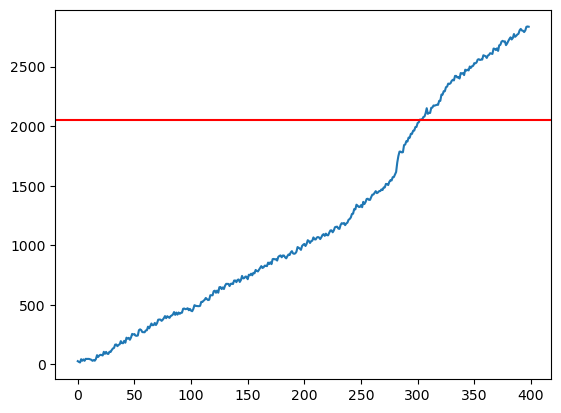

In [9]:
probeA_callosum_dist_from_tip = []
for i in range(len(A_probes)):
    try:
        callosum_middle_index = int(np.median(np.where(A_probes[i]['Region acronym'].values == 'ccb')))
    except:
        callosum_middle_index = int(np.median(np.where(A_probes[i]['Region acronym'].values == 'ccg')))
        
    callosum_um = A_probes[i]['Distance from first position [um]'][callosum_middle_index]

    if check_if_probe_is_flipped(A_probes[i]):
        callosum_dist_from_tip = callosum_um
    else:
        callosum_dist_from_tip = max(A_probes[i]['Distance from first position [um]']) - callosum_um
    probeA_callosum_dist_from_tip += [callosum_dist_from_tip]
probeA_callosum_dist_from_tip = np.mean(probeA_callosum_dist_from_tip)

plt.plot(mua_df_A.cluster_depth)
plt.axhline(probeA_callosum_dist_from_tip, color = 'red')
    
# now for probe A take everyhthing that is bellow the callosum
## add region to the dataframes
positions_ = []
for item in good_df_A.cluster_depth.values:
    if item < probeA_callosum_dist_from_tip:
        positions_+= ['striatum']
    else:
        positions_+= ['m_cortex']
good_df_A['Region'] = positions_

positions_ = []
for item in mua_df_A.cluster_depth.values:
    if item < probeA_callosum_dist_from_tip:
        positions_+= ['striatum']
    else:
        positions_+= ['m_cortex']
mua_df_A['Region'] = positions_

## Save out data 
s_path = org_directory + r"\ephys\probeA\non_curated_spikes\\"
if not os.path.isdir(s_path):
    os.mkdir(s_path)
    print('making path')
good_df_A.to_csv(s_path + 'good_units_df.csv')
mua_df_A.to_csv(s_path + 'multiunits_df.csv')


same for Probe B

LP appears second - good
LP appears second - good
LP appears second - good
LP appears second - good
making path


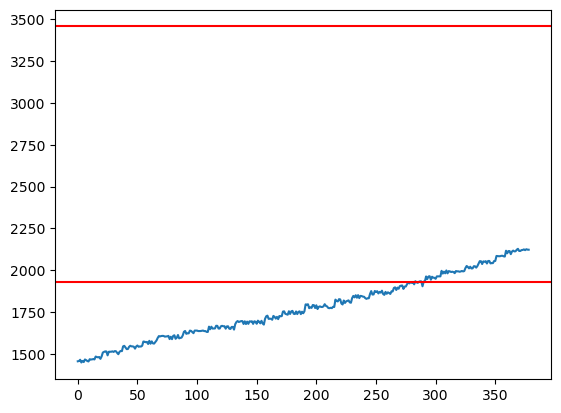

In [10]:

if probeB_bool:
    
    probeB_callosum_dist_from_tip = []
    probeB_thalamus_dist_from_tip = []
    for i in range(len(B_probes)):
        if 'cing' in B_probes[i]['Region acronym'].unique():
            callosum_middle_index = int(np.median(np.where(B_probes[i]['Region acronym'].values == 'cing')))
        elif 'ccs' in B_probes[i]['Region acronym'].unique():
            callosum_middle_index = int(np.median(np.where(B_probes[i]['Region acronym'].values == 'ccs')))

        thalamus_start_index = min(np.where(B_probes[i]['Region acronym'].values == 'LP')[0])

        # calculate um position
        callosum_um = B_probes[i]['Distance from first position [um]'][callosum_middle_index]
        thalamus_um = B_probes[i]['Distance from first position [um]'][thalamus_start_index]

        if check_if_probeB_is_flipped(B_probes[i]):
            callosum_dist_from_tip = callosum_um
            thalamus_dist_from_tip = thalamus_um
        else:
            callosum_dist_from_tip = max(B_probes[i]['Distance from first position [um]']) - callosum_um
            thalamus_dist_from_tip = max(B_probes[i]['Distance from first position [um]']) - thalamus_um

        probeB_callosum_dist_from_tip += [callosum_dist_from_tip]
        probeB_thalamus_dist_from_tip += [thalamus_dist_from_tip]

    # probeB_callosum_dist_from_tip = np.mean(probeB_callosum_dist_from_tip)
    probeB_callosum_dist_from_tip = np.mean(probeB_callosum_dist_from_tip)
    probeB_thalamus_dist_from_tip = np.mean(probeB_thalamus_dist_from_tip)

    plt.plot(mua_df_B.cluster_depth)
    plt.axhline(probeB_thalamus_dist_from_tip, color = 'red')
    plt.axhline(probeB_callosum_dist_from_tip, color = 'red')


    # for now just take all of the units - we trust Lars spectral alignment more than this histology alignment... 
    
    positions_ = []
    for item in good_df_B.cluster_depth.values:
        positions_+= ['undefined']
    good_df_B['Region'] = positions_

    positions_ = []
    for item in mua_df_B.cluster_depth.values:
        positions_+= ['undefined']
    mua_df_B['Region'] = positions_
    
    
    s_path = org_directory + r"\ephys\probeB\non_curated_spikes\\"
    if not os.path.isdir(s_path):
        os.mkdir(s_path)
        print('making path')
    good_df_B.to_csv(s_path + 'good_units_df.csv')
    mua_df_B.to_csv(s_path + 'multiunits_df.csv')

# Load in raw ephys data and compute gloabl timestamps 

In [11]:
import re
count = 0
for processor in os.listdir(OE_processor_path):
    if count == 0:
        main1 = int(re.findall(r'\d+', processor)[0])
        main1_2 = processor.split('.')[-1]
    elif count == 1:
        main2 = int(re.findall(r'\d+', processor)[0])
        main2_2 = processor.split('.')[-1]
    elif count == 2:
        main3 = int(re.findall(r'\d+', processor)[0])
        main3_2 = processor.split('.')[-1]
    count +=1 

main_processor_tuple=(main1, main1_2)

aux_processor_tuples=((main2,main2_2),(main3,main3_2))


############ DONT RUN MORE THAN ONCE! ITS SO SLOW! ######################

### LOAD in data: this could take a few minutes

# check to see if global object alreayd exists and fi it does... load premade one instead of doing it the slow way 
if process_probe_data_bool(organised_ephys_path,aux_processor_tuples) == True:
    
    recording = align_open_ephys_processors(main_processor_tuple,aux_processor_tuples,raw_data_directory)
    recording.compute_global_timestamps()
    
    ## Save this out:
    print('saving...')
    if not os.path.isdir(organised_ephys_path):
        os.makedirs(organised_ephys_path)
    save_path = organised_ephys_path + f"global-timstamps_event-df.pkl"
    recording.events.to_pickle(save_path)
    
    ## Extract timestamp data:
    events_df= recording.events

    main_continuous_global_ts_probeA = recording.continuous[0].global_timestamps
    save_path = organised_ephys_path + f"main_continuous_global_ts_probeA.npy"
    np.save(save_path,main_continuous_global_ts_probeA)
    if 'LFP' in aux_processor_tuples[0][-1]:
        print("No probe B detected")
        main_continuous_global_ts_probeA_LFP = recording.continuous[1].global_timestamps
        save_path = organised_ephys_path + f"main_continuous_global_ts_probeA_LFP.npy"
        np.save(save_path,main_continuous_global_ts_probeA_LFP)
    else:
        print("Probe B detected!")
        main_continuous_global_ts_probeB = recording.continuous[1].global_timestamps
        save_path = organised_ephys_path + f"main_continuous_global_ts_probeB.npy"
        np.save(save_path,main_continuous_global_ts_probeB)

else:
    print('already computed, loading event df...')
    events_df = pd.read_pickle(organised_ephys_path + 'global-timstamps_event-df.pkl')
    
    # # load in continuous ts data for each probe processor
    print('loading probe A continuous ts...')
    main_continuous_global_ts_probeA = np.load(organised_ephys_path + 'main_continuous_global_ts_probeA.npy')
    if not 'LFP' in aux_processor_tuples[0][-1]:
        print('loading probe B continuous ts...')
        main_continuous_global_ts_probeB = np.load(organised_ephys_path + 'main_continuous_global_ts_probeB.npy')
    
############ DONT RUN MORE THAN ONCE! ITS SO SLOW! ######################

# i believe line 2 is the 2nd ttl line which carries the Bpod TTLs to the nidaq
Bpod_NIDAQ_TTLS = events_df[events_df.line == 2]

### sort out offset:
ProbeB_exists = False
sync_messages_path = find_files("sync_messages.txt",raw_data_directory)[0]
sync = open(sync_messages_path, 'r')
lines = sync.readlines()
for line in lines:
    if 'Neuropix-PXI' in line:
        if 'ProbeA' in line:
            print(line)
            start_time_offset_A = int(re.findall(r'\d+', line)[-1]) / Fs
            print(start_time_offset_A)
            
        if 'ProbeB' in line:
            print(line)
            start_time_offset_B = int(re.findall(r'\d+', line)[-1]) / Fs
            print(start_time_offset_B)
            ProbeB_exists = True



this should be zero:
0
Processor ID: 100, Stream Name: ProbeA, Line: 1 (main sync line))
  First event sample number: 543368
  Last event sample number: 418469945
  Total sync events: 13932
  Sample rate: 30000.0
Processor ID: 100, Stream Name: ProbeB, Line: 1 (aux sync line))
  First event sample number: 543368
  Last event sample number: 418469945
  Total sync events: 13932
  Scale factor: 1.0
  Actual sample rate: 30000.0
Processor ID: 102, Stream Name: PXIe-6341, Line: 1 (aux sync line))
  First event sample number: 731804
  Last event sample number: 557972015
  Total sync events: 13932
  Scale factor: 0.7499935732383821
  Actual sample rate: 40000.342763556764
saving...
Probe B detected!
Start Time for Neuropix-PXI (100) - ProbeA @ 30000 Hz: 525810

17.527
Start Time for Neuropix-PXI (100) - ProbeB @ 30000 Hz: 525312

17.5104


# find the start of each behavioural epoch (sleep, task, sleep)

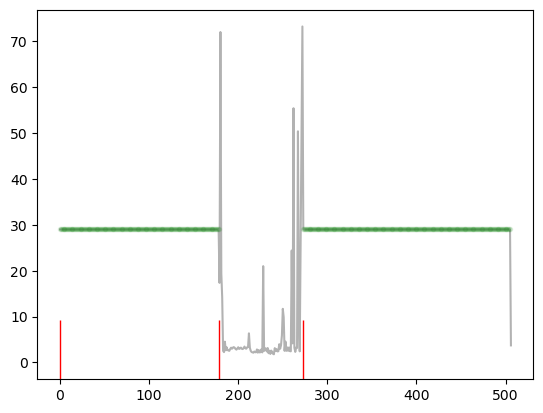

In [12]:
## split into 3 sperates epochs based on triggers
# find trigger onset times
trigger_onset_times = Bpod_NIDAQ_TTLS[Bpod_NIDAQ_TTLS.state == 0]['global_timestamp']

sleep_trigger_inds = np.where((np.diff(trigger_onset_times) > 28.5) & (np.diff(trigger_onset_times) < 31.5))[0]

plt.plot(np.diff(Bpod_NIDAQ_TTLS['global_timestamp'])[1::2], color = 'k', alpha = 0.3)
plt.plot(np.array(sleep_trigger_inds),np.diff(Bpod_NIDAQ_TTLS['global_timestamp'])[1::2][sleep_trigger_inds],'o',alpha = 0.1, color = 'green',markersize = 3)

consecutive_chunks = []
start = None
for i in range(len(sleep_trigger_inds) - 1):
    if sleep_trigger_inds[i + 1] - sleep_trigger_inds[i] == 1:
        if start is None:
            start = sleep_trigger_inds[i]
    else:
        if start is not None:
            end = sleep_trigger_inds[i]
            consecutive_chunks.append((start*2, end*2))
            start = None
if start is not None:
    # *2 because the original array was the diff of the TTL on and off periods and this is just TTL onsets
    consecutive_chunks.append((start*2, sleep_trigger_inds[-1]*2))
    
plt.plot(consecutive_chunks[0][-1]/2,0,'|',markersize = 60, color = 'red')
plt.plot(consecutive_chunks[0][0]/2,0,'|',markersize = 60, color = 'red')
plt.plot(consecutive_chunks[-1][0]/2,0,'|',markersize = 60, color = 'red')


behaviour_barcode_index = consecutive_chunks[0][-1]
presleep_barcode_index = consecutive_chunks[0][0]
postsleep_barcode_index = consecutive_chunks[-1][0]

# load behaviour and check alignment

In [13]:
# load in behavioural data           
Full_Behav_data_path = list(os.walk(Behav_data_path))[-1][0]  
print(Full_Behav_data_path)
poke_data =  pd.read_csv(Full_Behav_data_path + "/PreProcessed_RawPokeData.csv") 

first_poke_times = find_first_poke_times((poke_data['Trial_id']),list(poke_data['Port']), np.array(poke_data['PokeIn_Time']))
all_timestamps = sorted(list(first_poke_times) + list(np.unique(poke_data['Trial_Start'])))

Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq006_implant1\recording1_15-11-2024//behav_sync/2_task/Preprocessed//00_20241115_111239_Fri


5


(-0.1, 0.1)

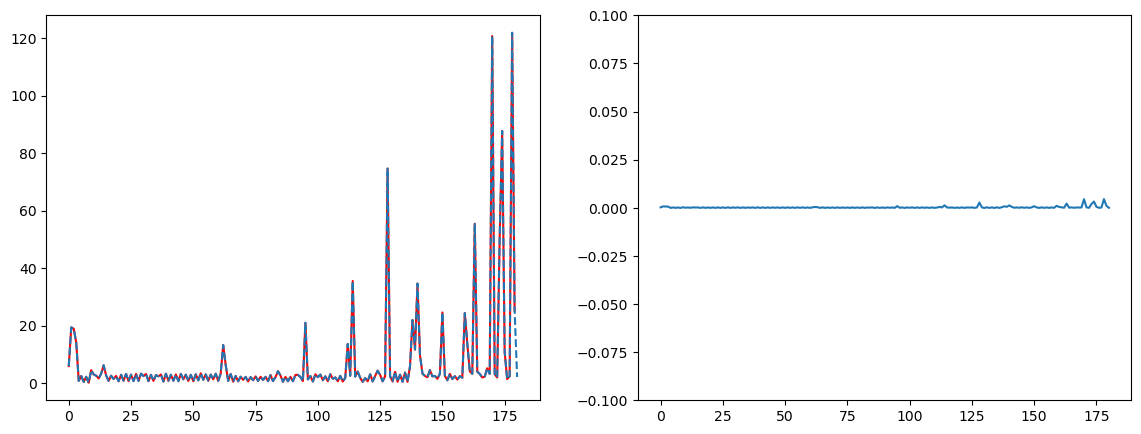

In [14]:
## plot the timestamps (difffernces) to see if they overlay perfectly 

## adjust as needed 
for manual_offset in range(0,100):
    NIDAQ_ts_diff = np.diff(Bpod_NIDAQ_TTLS['global_timestamp'][behaviour_barcode_index+manual_offset:postsleep_barcode_index])
    behaviour_ts_diff = np.diff(all_timestamps)
    if np.max(NIDAQ_ts_diff[1:len(all_timestamps)] - behaviour_ts_diff) < 0.1:
        print(manual_offset)
        break

# manual_offset =13

NIDAQ_ts_diff = np.diff(Bpod_NIDAQ_TTLS['global_timestamp'][behaviour_barcode_index+manual_offset:postsleep_barcode_index])
behaviour_ts_diff = np.diff(all_timestamps)


fig, [ax,ax1] = plt.subplots(1, 2, figsize=(14, 5))
ax.plot(NIDAQ_ts_diff[1:len(behaviour_ts_diff)], color = 'red') ## 1:: because the behaviour starts from diff between trial and first poke while ephys starts from barcode/start point end to trial start 
ax.plot(behaviour_ts_diff,'--')
# ax.set_xlim([0, 120])

## plot the difference between the two to see if there is misalingment between the two timestamp sets: 
plt.plot(NIDAQ_ts_diff[1:len(all_timestamps)] - behaviour_ts_diff)
plt.ylim([-0.1, 0.1])


# Align ephys timestamps and behaviour 

start end diffs
for ephys ts:      1172.0593065195844
for behav ts:      1172.0153


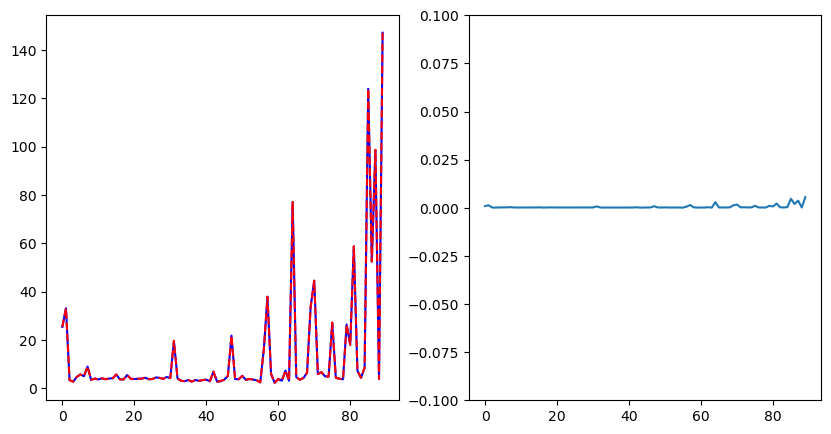

In [15]:
#### align timestamps to behaviour

behav_NIDAQ_events = Bpod_NIDAQ_TTLS[behaviour_barcode_index+manual_offset:postsleep_barcode_index]
all_NIDAQ_TS = behav_NIDAQ_events['global_timestamp'].values

all_states = np.array(behav_NIDAQ_events['state'])
up_ticks_inds = np.where(all_states == 1)
down_ticks_inds = np.where(all_states == 0)

trial_start_TS = np.unique(poke_data['Trial_Start'])
first_poke_TS = np.array(sorted(list(first_poke_times)))

## up ticks - trials start - alignment
aligned_trial_starts_ephys_TS = all_NIDAQ_TS[up_ticks_inds][0:len(trial_start_TS)]


fig, [ax,ax1] = plt.subplots(1, 2, figsize=(10, 5))
ax.plot(np.diff(aligned_trial_starts_ephys_TS), color = 'blue')
ax.plot(np.diff(trial_start_TS), '--',color = 'red')
# plt.xlim([380, 415])
# plt.xlim([60, 100])

ax1.plot(np.diff(aligned_trial_starts_ephys_TS)-np.diff(trial_start_TS))
ax1.set_ylim([-0.1, 0.1])

print('start end diffs')
print('for ephys ts:      '+ str(aligned_trial_starts_ephys_TS[-1] - aligned_trial_starts_ephys_TS[0]))
print('for behav ts:      ' + str(trial_start_TS[-1] -  trial_start_TS[0])) 

(-0.1, 0.1)

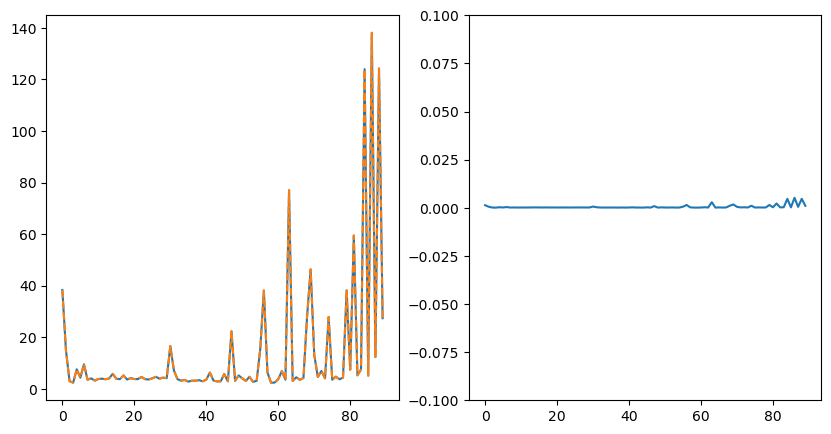

In [16]:
## up ticks - first poke - alignment
fig, [ax,ax1] = plt.subplots(1, 2, figsize=(10, 5))

aligned_first_poke_ephys_TS = all_NIDAQ_TS[down_ticks_inds][1:len(first_poke_TS)+1]

ax.plot(np.diff(aligned_first_poke_ephys_TS))
ax.plot(np.diff(first_poke_TS),'--')
# plt.xlim([380, 415])
# plt.xlim([0, 40])

ax1.plot(np.diff(aligned_first_poke_ephys_TS)-np.diff(first_poke_TS))
ax1.set_ylim([-0.1, 0.1])

# aligne all poke in and out events to nearest ephys trigger

In [17]:
# convert from global timestamps to Probe A/B processor time (as this is what kilosort uses)
# find index in main (NPX spike band) for all events in the recording. Find the smaple index that corresponds with the global timestamp 
# then convert this to relative time for that processor (kilosort time) by dividing sample number by same rate    

## Probe A:
global_ts_in_main_samples = np.searchsorted( main_continuous_global_ts_probeA,aligned_trial_starts_ephys_TS)
aligned_trial_starts_ephys_TS_synced_A = global_ts_in_main_samples/Fs

global_ts_in_main_samples = np.searchsorted( main_continuous_global_ts_probeA,aligned_first_poke_ephys_TS)
aligned_first_poke_ephys_TS_synced_A = global_ts_in_main_samples/Fs

#Probe B
if ProbeB_exists:
    global_ts_in_main_samples = np.searchsorted( main_continuous_global_ts_probeB,aligned_trial_starts_ephys_TS)
    aligned_trial_starts_ephys_TS_synced_B = global_ts_in_main_samples/Fs

    global_ts_in_main_samples = np.searchsorted( main_continuous_global_ts_probeB,aligned_first_poke_ephys_TS)
    aligned_first_poke_ephys_TS_synced_B = global_ts_in_main_samples/Fs



In [18]:
PokeIn_Times = list(poke_data['PokeIn_Time'])
PokeOut_Times = list(poke_data['PokeOut_Time'])
                               
trial_start = list(poke_data['Trial_Start'])
trial_id = list(poke_data['Trial_id'])

# PROBE A
PokeInTimes_Ephys_TS_A = AlignToTriggersAndFIndEphysTimestamps(PokeIn_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS_synced_A,aligned_first_poke_ephys_TS_synced_A)
PokeOutTimes_Ephys_TS_A = AlignToTriggersAndFIndEphysTimestamps(PokeOut_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS_synced_A,aligned_first_poke_ephys_TS_synced_A)

df_aligned_firstpoke_ephys_ts_A = align_firstpoke_camera_timestamps(list(poke_data['Trial_id']), aligned_first_poke_ephys_TS_synced_A ,list(poke_data['Port']))
df_aligned_trialstart_ephys_ts_A = align_trial_start_end_timestamps(list(poke_data['Trial_id']),aligned_trial_starts_ephys_TS_synced_A)

#Probe B
if ProbeB_exists:
    PokeInTimes_Ephys_TS_B = AlignToTriggersAndFIndEphysTimestamps(PokeIn_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS_synced_B,aligned_first_poke_ephys_TS_synced_B)
    PokeOutTimes_Ephys_TS_B = AlignToTriggersAndFIndEphysTimestamps(PokeOut_Times,trial_id,first_poke_TS,trial_start_TS,aligned_trial_starts_ephys_TS_synced_A,aligned_first_poke_ephys_TS_synced_B)

    df_aligned_firstpoke_ephys_ts_B = align_firstpoke_camera_timestamps(list(poke_data['Trial_id']), aligned_first_poke_ephys_TS_synced_B ,list(poke_data['Port']))
    df_aligned_trialstart_ephys_ts_B = align_trial_start_end_timestamps(list(poke_data['Trial_id']),aligned_trial_starts_ephys_TS_synced_B)


## add to dataframe
poke_data['TrialStart_EphysTime'] = np.array(df_aligned_trialstart_ephys_ts_A)
poke_data['FirstPoke_EphysTime'] = df_aligned_firstpoke_ephys_ts_A

poke_data['PokeIN_EphysTime'] = PokeInTimes_Ephys_TS_A 
poke_data['PokeOUT_EphysTime'] = PokeOutTimes_Ephys_TS_A

if ProbeB_exists:
    poke_data['TrialStart_EphysTime_ProbeB'] = np.array(df_aligned_trialstart_ephys_ts_B)
    poke_data['FirstPoke_EphysTime_ProbeB'] = df_aligned_firstpoke_ephys_ts_B

    poke_data['PokeIN_EphysTime_ProbeB'] = PokeInTimes_Ephys_TS_B 
    poke_data['PokeOUT_EphysTime_ProbeB'] = PokeOutTimes_Ephys_TS_B


## hack if there is a NaN at the end:
# PokeOUT_EphysTime = np.append(np.array(PokeOutTimes_Ephys_TS[0:-1]),'NaN')


Make transition dataframe

In [19]:
Port_intimes = list(poke_data['PokeIn_Time'])
Port_outtimes = list(poke_data['PokeOut_Time'])
Ports = list(poke_data['Port'])

#Determine Transition times and types for all events 
out_in_Transition_times, in_in_Transition_times, Transition_types, out_in_transition_reference,in_in_transition_reference = Determine_Transition_Times_and_Types(Port_intimes,Port_outtimes,Ports)

#Split transtion types into first and last ports: 
start_port_ids = Start_End_port_id(Transition_types,0)
end_port_ids = Start_End_port_id(Transition_types,1)

#Align start and end port time
End_Port_in_time = Port_intimes[1::]
Start_Port_in_time = Port_intimes[0:-1]
End_Port_out_time = Port_outtimes[1::]
Start_Port_out_time = Port_outtimes[0:-1]

#Find Port repeat events (double pokes)
Non_Port_repeat = determine_RepeatPort_events(start_port_ids,end_port_ids)

#Determine which transitions are good: less than 1.5s
out_in_Filtered_transitions = filter_transitons_by_latency(out_in_Transition_times, 2)
in_in_Filtered_transitions = filter_transitons_by_latency(in_in_Transition_times, 2)

In [20]:
# make dataframe:
Transition_df = pd.DataFrame(
    {'Trial_id' : poke_data['Trial_id'][0:-1],
    'Transition_type' : Transition_types,
     'Start_Port':start_port_ids, 
     'End_Port':end_port_ids,
     'Start_Poke_in_time': Start_Port_in_time,
     'Start_Poke_out_time': Start_Port_out_time,
     'End_Poke_in_time': End_Port_in_time,
     'End_Poke_out_time': End_Port_out_time,
     'out_in_Latency' : out_in_Transition_times,
     'in_in_Latency': in_in_Transition_times,
     '2s_Time_Filter_out_in': out_in_Filtered_transitions,
     '2s_Time_Filter_in_in': in_in_Filtered_transitions,
     'Port 2,3,4,5 LED intensities': poke_data['Port 2,3,4,5 LED intensities'][0:-1],
     'Port 1,2,3,4 RewardAmount':poke_data['Port 1,2,3,4 RewardAmount'][0:-1],
     'Repeat_Filter':Non_Port_repeat,
     'P1_IN_Ephys_TS': poke_data['PokeIN_EphysTime'].values[0:-1],
     'P1_OUT_Ephys_TS': poke_data['PokeOUT_EphysTime'].values[0:-1],
     'P2_IN_Ephys_TS': poke_data['PokeIN_EphysTime'].values[1::],
     'P2_OUT_Ephys_TS': poke_data['PokeOUT_EphysTime'].values[1::]
    })

if ProbeB_exists:
    Transition_df['P1_IN_Ephys_TS_ProbeB']: poke_data['PokeIN_EphysTime_ProbeB'].values[0:-1]
    Transition_df['P1_OUT_Ephys_TS_ProbeB']: poke_data['PokeOUT_EphysTime_ProbeB'].values[0:-1]
    Transition_df['P2_IN_Ephys_TS_ProbeB']: poke_data['PokeIN_EphysTime_ProbeB'].values[1::]
    Transition_df['P2_OUT_Ephys_TS_ProbeB']: poke_data['PokeOUT_EphysTime_ProbeB'].values[1::]


# now align the cameras

load in camera ts files

In [21]:
from pathlib import Path

cam_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1])) + r'\video\videos\\'

# find csv file 
csv_files = [f for f in os.listdir(cam_path) if f.endswith('.csv')]

for csv_file in csv_files:
    if 'BACK' in csv_file:
        print(csv_file)
        cam_ts = pd.read_csv(cam_path + csv_file)
        break




BACK_camera_timestamp_df_seq006_15-11-2024.csv


# align task period

blue x should be at uptick - bottom
red should be a downtick - top


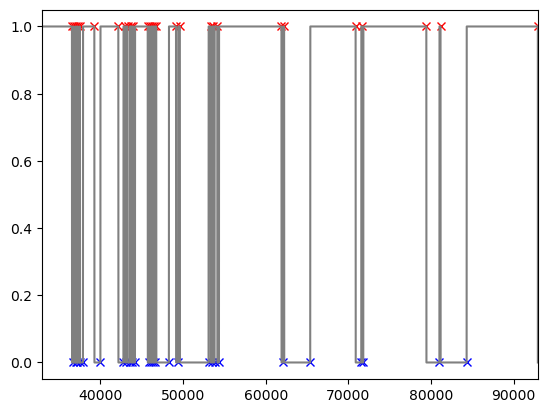

In [22]:
behav_cam_ts = cam_ts[cam_ts.epoch == 'task']

# find camera triggers: 

Camera_trig_states = behav_cam_ts['Trigger State'].values

where_ttl_changes = list(np.where(np.roll(Camera_trig_states,1)!=Camera_trig_states)[0])
if where_ttl_changes[0] == 0:
    where_ttl_changes = where_ttl_changes[1::]

## check this is correct:
plt.plot(np.array(where_ttl_changes[1::2]),np.ones(len(np.array(where_ttl_changes[1::2]))),'x', color = 'red')
plt.plot(np.array(where_ttl_changes[0::2]),np.zeros(len(np.array(where_ttl_changes[0::2]))),'x',color = 'blue')
plt.plot(behav_cam_ts['Trigger State'].values, color = 'grey')
plt.xlim([max(where_ttl_changes)-60000, max(where_ttl_changes)])

print('blue x should be at uptick - bottom')
print('red should be a downtick - top') 

# turn these into time stamp values
Poke1_camera_ts = behav_cam_ts['Time Stamps'].values[np.array(where_ttl_changes[1::2])]
Trial_start_camera_ts= behav_cam_ts['Time Stamps'].values[np.array(where_ttl_changes[0::2])]


3


(-0.5, 0.5)

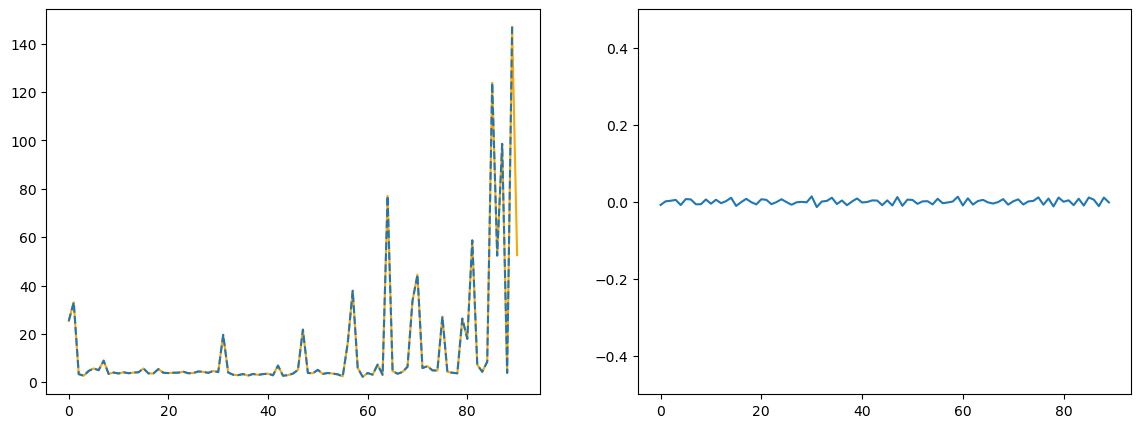

In [23]:
for manual_offset in range(0,100):
    Trial_start_camera_ts_reset = Trial_start_camera_ts[manual_offset::]
    a = Trial_start_camera_ts_reset[0:len(poke_data.Trial_Start.unique())]
    b = poke_data.Trial_Start.unique()
    if max(np.diff(a) - np.diff(b))< 0.1:
        print(manual_offset)
        break

# manual_offset = 4

Trial_start_camera_ts_reset = Trial_start_camera_ts[manual_offset::]

fig, [ax,ax1] = plt.subplots(1, 2, figsize=(14, 5))
ax.plot(np.diff(Trial_start_camera_ts_reset), color = 'orange')
ax.plot(np.diff(poke_data.Trial_Start.unique()),'--')
# plt.xlim([260, 290])
# plt.xlim([0, 50])

a = Trial_start_camera_ts_reset[0:len(poke_data.Trial_Start.unique())]
b = poke_data.Trial_Start.unique()

ax1.plot(np.diff(a) - np.diff(b))
ax1.set_ylim([-0.5, 0.5])


trim length and check alingment one final time

(-0.5, 0.5)

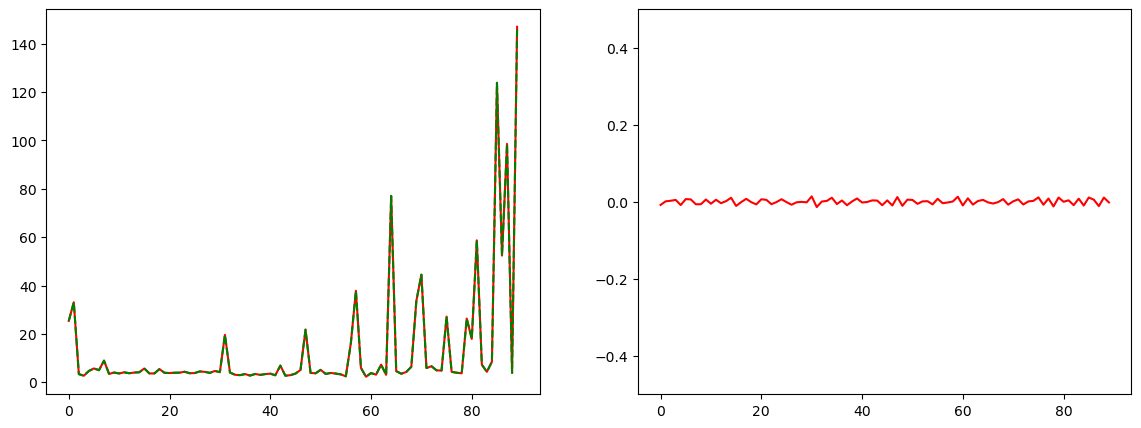

In [24]:
# perform fix: # puts a nan value where it detects ther is a missing trigger

# old fix method - not 100% sure what it actually does...
# fixed = test_timestamps_(trial_start_bpod_ts,Trial_start_camera_ts_reset)
# fixed_Trial_start_camera_ts = fixed[0:len(trial_start_bpod_ts)]


### trim data down to the same length:
trial_start_bpod_ts = poke_data.Trial_Start.unique()
fixed_Trial_start_camera_ts = Trial_start_camera_ts_reset[0:len(poke_data.Trial_Start.unique())]

fig, [ax,ax1] = plt.subplots(1, 2, figsize=(14, 5))
ax.plot(np.diff(fixed_Trial_start_camera_ts),color = 'red')
ax.plot(np.diff(poke_data.Trial_Start.unique()), '--', color = 'green')#

ax1.plot(np.diff(fixed_Trial_start_camera_ts) - np.diff(poke_data.Trial_Start.unique()), color = 'red')
ax1.set_ylim([-.5, 0.5])




check alingment makes sense in terms of start to end time difference

In [25]:
print('start end diffs')
print('for ephys ts:      '+ str((fixed_Trial_start_camera_ts)[-1] - (fixed_Trial_start_camera_ts)[0]))
print('for behav ts:      ' + str(trial_start_bpod_ts[-1] -  trial_start_bpod_ts[0])) 

count = 0
for item in (np.diff(fixed_Trial_start_camera_ts) - np.diff(poke_data.Trial_Start.unique())):
    if not np.isnan(item):
        count = count + item 
print('ofset tot is:   ' + str(count))

start end diffs
for ephys ts:      1172.0438732480006
for behav ts:      1172.0153
ofset tot is:   0.028573248000597573


# align timestamps and make dataframe

In [26]:
### align fixed and checked timestamps:
if not len(poke_data.Trial_id.unique()) == len(fixed_Trial_start_camera_ts):
    print('num trials and trial start TTLs not the same length...this could cause issues')
    
back_aligned_time = align_to_start_ts(poke_data.Trial_id.values,fixed_Trial_start_camera_ts)
back_pokein_times = align_allpokes_to_cam_trialstart(poke_data.Trial_id.values, poke_data.Trial_Start.unique(), poke_data.PokeIn_Time.values,fixed_Trial_start_camera_ts)
back_pokeout_times = align_allpokes_to_cam_trialstart(poke_data.Trial_id.values, poke_data.Trial_Start.unique(), poke_data.PokeOut_Time.values,fixed_Trial_start_camera_ts)


### make a new dataframe:

new_PortIn_df = pd.DataFrame(
    {'Trial_id' : poke_data.Trial_id.values,
     'Trial_Start' : poke_data.Trial_Start.values,
     'Port': poke_data.Port.values,
     'PokeIn_Time': poke_data.PokeIn_Time.values,
     'PokeOut_Time': poke_data.PokeOut_Time.values,
     'Reward_Times': poke_data.Reward_Times.values,
     'Trial_End' : poke_data.Trial_End.values,
     'Port_2-3-4-5_LED_intensities': poke_data['Port 2,3,4,5 LED intensities'].values,
     'Port_1-2-3-4_RewardAmount': poke_data['Port 1,2,3,4 RewardAmount'].values,
     'TrainingLevel': poke_data.TrainingLevel.values,
     
     'TrialStart_EphysTime': poke_data.TrialStart_EphysTime.values,
     'FirstPoke_EphysTime': poke_data.FirstPoke_EphysTime.values,
     'PokeIN_EphysTime': poke_data.PokeIN_EphysTime.values,
     'PokeOUT_EphysTime': poke_data.PokeOUT_EphysTime.values,
    
     'backcam_trialstart_seconds':back_aligned_time,
     'backcam_aligned_pokein_times':back_pokein_times,
     'backcam_aligned_pokeout_times':back_pokeout_times,
     'backcam_trialstart_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_aligned_time),
     'backcam_pokein_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokein_times),
     'backcam_pokeout_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokeout_times)
    })

100%|███████████████████████████████████████████████████████████████████████████████████| 610/610 [00:00<00:00, 3691.18it/s]


do the same for the transition dataframe

In [27]:
Port_intimes = new_PortIn_df.PokeIn_Time.values
Port_outtimes = new_PortIn_df.PokeOut_Time.values
Ports = new_PortIn_df.Port.values

#Determine Transition times and types for all events 
out_in_Transition_times, in_in_Transition_times, Transition_types, out_in_transition_reference,in_in_transition_reference = Determine_Transition_Times_and_Types(Port_intimes,Port_outtimes,Ports)

#Split transtion types into first and last ports: 
start_port_ids = Start_End_port_id(Transition_types,0)
end_port_ids = Start_End_port_id(Transition_types,1)

#Align start and end port time
End_Port_in_time = Port_intimes[1::]
Start_Port_in_time = Port_intimes[0:-1]
End_Port_out_time = Port_outtimes[1::]
Start_Port_out_time = Port_outtimes[0:-1]

#Find Port repeat events (double pokes)
Non_Port_repeat = determine_RepeatPort_events(start_port_ids,end_port_ids)

#Determine which transitions are good: less than 1.5s
out_in_Filtered_transitions = filter_transitons_by_latency(out_in_Transition_times, 2)
in_in_Filtered_transitions = filter_transitons_by_latency(in_in_Transition_times, 2)

In [28]:
# make dataframe:
new_Transition_df = pd.DataFrame(
    {'Trial_id' : new_PortIn_df['Trial_id'][0:-1],
    'Transition_type' : Transition_types,
     'Start_Port':start_port_ids, 
     'End_Port':end_port_ids,
     'Start_Poke_in_time': Start_Port_in_time,
     'Start_Poke_out_time': Start_Port_out_time,
     'End_Poke_in_time': End_Port_in_time,
     'End_Poke_out_time': End_Port_out_time,
     'out_in_Latency' : out_in_Transition_times,
     'in_in_Latency': in_in_Transition_times,
     '2s_Time_Filter_out_in': out_in_Filtered_transitions,
     '2s_Time_Filter_in_in': in_in_Filtered_transitions,
     'Port_2-3-4-5_LED_intensities': new_PortIn_df['Port_2-3-4-5_LED_intensities'].values[0:-1],
     'Port_1-2-3-4_RewardAmount': new_PortIn_df['Port_1-2-3-4_RewardAmount'].values[0:-1],
     'Repeat_Filter':Non_Port_repeat,
     
     'TrialStart_EphysTime': new_PortIn_df.TrialStart_EphysTime.values[0:-1],
     'FirstPoke_EphysTime': new_PortIn_df.FirstPoke_EphysTime.values[0:-1],
     'P1_IN_Ephys_TS': new_PortIn_df.PokeIN_EphysTime.values[0:-1],
     'P1_OUT_Ephys_TS': new_PortIn_df.PokeOUT_EphysTime.values[0:-1],
     'P2_IN_Ephys_TS': new_PortIn_df.PokeIN_EphysTime.values[1::],
     'P2_OUT_Ephys_TS': new_PortIn_df.PokeOUT_EphysTime.values[1::],
     
     'backcam_trialstart_seconds':back_aligned_time[0:-1],
     'backcam_aligned_P1In_times':back_pokein_times[0:-1],
     'backcam_aligned_P1Out_times':back_pokeout_times[0:-1],
     'backcam_aligned_P2In_times':back_pokein_times[1::],
     'backcam_aligned_P2Out_times':back_pokeout_times[1::],
     
     'backcam_trialstart_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_aligned_time)[0:-1],
     'backcam_P1In_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokein_times)[0:-1],
     'backcam_P1Out_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokeout_times)[0:-1],
     'backcam_P2In_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokein_times)[1::],
     'backcam_P2Out_closest_cameraframes': find_closest_cameraframe_index(behav_cam_ts, back_pokeout_times)[1::],
     
    
    })

100%|███████████████████████████████████████████████████████████████████████████████████| 610/610 [00:00<00:00, 4166.65it/s]


## run alignment checks! 

In [29]:
# tracking 
# behav_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1])) + r'\video\tracking\2_task\\'
behav_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1])) + r'\video\tracking\\'


# load in tracking data 
for t_file in os.listdir(behav_path):
    if '.h5' in t_file:
        print(t_file)
        tracking_file = behav_path+t_file
        if 'PORTS' in t_file:
            ports = load_H5_bodypart_ports(tracking_file)
            p1_all,p2_all,p3_all,p4_all,p5_all = ports[0::]
        elif 'BACK' in t_file:
            back_head_centre_all = load_H5_bodypart_ports(tracking_file)[0]
            
task_epoch_start = np.where(cam_ts.epoch == 'task')[0][0]
task_epoch_end = np.where(cam_ts.epoch == 'task')[0][-1]

print(len(cam_ts))
print(len(back_head_centre_all))
print(len(p1_all))

## trim down to task relevant part
back_head_centre = back_head_centre_all[task_epoch_start:task_epoch_end]
p1 = p1_all[task_epoch_start:task_epoch_end]
p2 = p2_all[task_epoch_start:task_epoch_end]
p3 = p3_all[task_epoch_start:task_epoch_end]
p4 = p4_all[task_epoch_start:task_epoch_end]
p5 = p5_all[task_epoch_start:task_epoch_end]


ABOVE_CAM_seq006_15-11-2024DLC_resnet50_ABOVE_generalDec4shuffle1_650000.h5
BACK_CAM_seq006_15-11-2024DLC_resnet50_BACK_hippocampusDec10shuffle1_800000.h5
BACK_CAM_seq006_15-11-2024DLC_resnet50_BACK_PORTS_hpc_rigDec4shuffle1_640000.h5
871482
871482
871482


red - port 1
green - port 6
blue - port 3


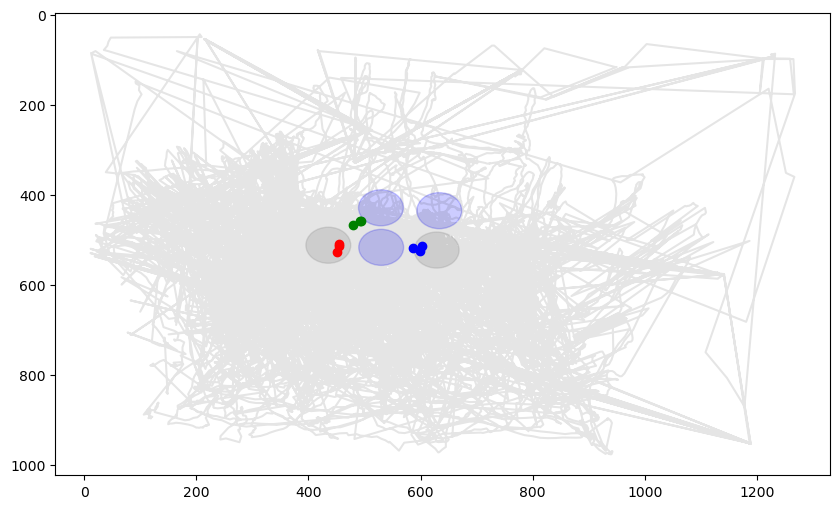

In [30]:
port_centroids = [(np.median(p1.x),np.median(p1.y)),(np.median(p2.x),np.median(p2.y)),(np.median(p3.x),np.median(p3.y)),(np.median(p4.x),np.median(p4.y)),(np.median(p5.x),np.median(p5.y))]

fig, ax = plt.subplots(1, 1,figsize=(10, 6))
for index,port_centroid in enumerate(port_centroids):
    ## define rings around important ports: port 5, port2, port 3, port4
    radius = 40
    ax.plot(port_centroid[0],port_centroid[1],'o',alpha = 0)
    c = ['blue','grey','blue','grey','blue']
    circle = plt.Circle(port_centroid, radius, color=c[index], alpha = 0.2)
    ax.add_patch(circle)
ax.invert_yaxis()

start_ = 0
end_ = -1
x_ = back_head_centre.interped_x.values
y_ = back_head_centre.interped_y.values

ax.plot(x_[start_:end_],y_[start_:end_], '-',color = 'black', alpha = 0.1)

port1_inds = [np.where(new_PortIn_df.Port.values == 1)[0][10], np.where(new_PortIn_df.Port.values == 1)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 1)[0][-10]]
port3_inds = [np.where(new_PortIn_df.Port.values == 3)[0][10], np.where(new_PortIn_df.Port.values == 3)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 3)[0][-5]]
port6_inds = [np.where(new_PortIn_df.Port.values == 6)[0][10], np.where(new_PortIn_df.Port.values == 6)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 6)[0][-5]]

closest_inds1= []
for ind in port1_inds:
    current_poke_in_time = back_pokein_times[ind]
    # find the ind where the camera timestamp is closest to the poke in time
    closest_inds1 += [np.argmin(np.abs(behav_cam_ts['Time Stamps'].values - current_poke_in_time))]
for ind in closest_inds1:
    ax.plot(x_[ind],y_[ind],'o', color = 'red')
    
closest_inds6= []
for ind in port6_inds:
    current_poke_in_time = back_pokein_times[ind]
    # find the ind where the camera timestamp is closest to the poke in time
    closest_inds6 += [np.argmin(np.abs(behav_cam_ts['Time Stamps'].values - current_poke_in_time))]
for ind in closest_inds6:
    ax.plot(x_[ind],y_[ind],'o', color = 'green')
    
closest_inds3= []
for ind in port3_inds:
    current_poke_in_time = back_pokein_times[ind]
    # find the ind where the camera timestamp is closest to the poke in time
    closest_inds3 += [np.argmin(np.abs(behav_cam_ts['Time Stamps'].values - current_poke_in_time))]
for ind in closest_inds3:
    ax.plot(x_[ind],y_[ind],'o', color = 'blue')
    
print('red - port 1')
print('green - port 6') 
print('blue - port 3') 


make test videos 

In [31]:

# # Specify the directory
# dir_path = r'D:\\camera_test\\'
# # Get a list of all files in the directory
# files = glob.glob(os.path.join(dir_path, '*'))
# # Loop through the files and delete each one
# for file in files:
#     os.remove(file)
# print("All files deleted in the directory:", dir_path)

# if not os.path.isdir(dir_path):
#     os.mkdir(dir_path)

# for ind in closest_inds1:
#     camera_frame = ind + behav_cam_ts.index[0]
#     start_frame_number = camera_frame-20
#     end_frame_number = camera_frame	
#     output_video_path = dir_path +'port3_'+str(ind) + '_back_test.mp4'
#     extract_frames_by_number(back_video_path, output_video_path, start_frame_number, end_frame_number)



# SAVE OUT THE DATAFRAMES

In [32]:
#if alignment is good then save out the data:

out_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1]))
out_path = out_path + r'\behav_sync\\2_task\\'
print(out_path)

new_PortIn_df.to_csv(out_path +'Behav_Ephys_Camera_Sync.csv')

new_Transition_df.to_csv(out_path +'Transition_data_sync.csv')


print('data checked?')
print('data Saved')

Z:\\projects\sequence_squad\revision_data\organised_data\animals\seq006_implant1\recording1_15-11-2024\behav_sync\\2_task\\
data checked?
data Saved


# PRE/POSTSLEEP - load camera data

load data

In [33]:
# now align the cameras

#load in abive camera ts files
from pathlib import Path

cam_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1])) + r'\video\videos\\'

# find csv file 
csv_files = [f for f in os.listdir(cam_path) if f.endswith('.csv')]

for csv_file in csv_files:
    if 'ABOVE' in csv_file:
        print(csv_file)
        cam_ts = pd.read_csv(cam_path + csv_file)
        break


ABOVE_camera_timestamp_df_seq006_15-11-2024.csv


# presleep

blue x should be at uptick - bottom
red should be a downtick - top


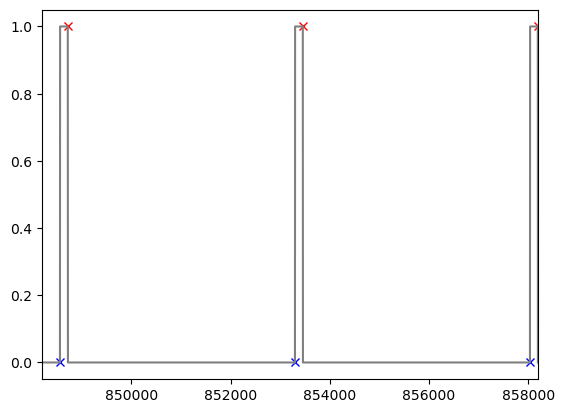

In [34]:
presleep_cam_ts = cam_ts[cam_ts.epoch == 'presleep'].reset_index()

### find camera triggers: 

Camera_trig_states = presleep_cam_ts['Trigger State'].values

where_ttl_changes = list(np.where(np.roll(Camera_trig_states,1)!=Camera_trig_states)[0])
if where_ttl_changes[0] == 0:
    where_ttl_changes = where_ttl_changes[1::]
down_tick = np.array(where_ttl_changes[1::2])
up_tick = np.array(where_ttl_changes[0::2])

## check this is correct:
plt.plot(down_tick,np.ones(len(down_tick)),'x', color = 'red')
plt.plot(up_tick,np.zeros(len(up_tick)),'x',color = 'blue')
plt.plot(Camera_trig_states, color = 'grey')
plt.xlim([max(where_ttl_changes)-10000, max(where_ttl_changes)])


print('blue x should be at uptick - bottom')
print('red should be a downtick - top') 

### set ts variables:
cam_trigger_times = presleep_cam_ts['Time Stamps'][where_ttl_changes].values
ephys_ts = Bpod_NIDAQ_TTLS['global_timestamp'][presleep_barcode_index:behaviour_barcode_index].values


(-0.5, 0.5)

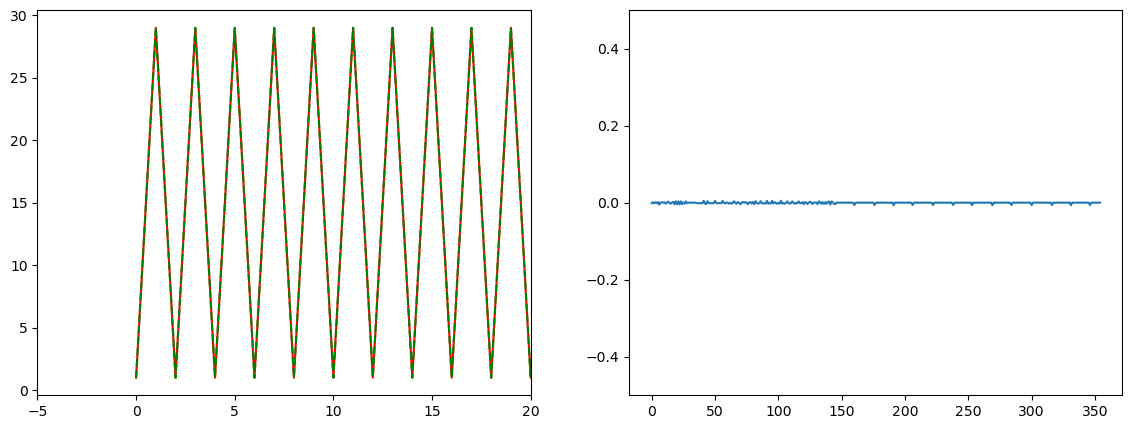

In [35]:
fig, [ax,ax1] = plt.subplots(1, 2, figsize=(14, 5))
ax.plot(np.diff(cam_trigger_times),color = 'red')
ax.plot(np.diff(ephys_ts), '--', color = 'green')
ax.set_xlim([-5, 20])

ax1.plot(np.diff(cam_trigger_times) - np.diff(ephys_ts))
ax1.set_ylim([-0.5, 0.5])

In [36]:
# convert from global timestamps to Probe A/B processor time (as this is what kilosort uses)
# find index in main (NPX spike band) for all events in the recording. Find the smaple index that corresponds with the global timestamp 
# then convert this to relative time for that processor (kilosort time) by dividing sample number by same rate    

## Probe A:
global_ts_in_main_samples = np.searchsorted( main_continuous_global_ts_probeA,ephys_ts)
ephys_times_synced_A = global_ts_in_main_samples/Fs

#Probe B
if ProbeB_exists:
    global_ts_in_main_samples = np.searchsorted( main_continuous_global_ts_probeB,ephys_ts)
    ephys_times_synced_B = global_ts_in_main_samples/Fs
    
###### add things to dataframe
# add new columns
camera_times_s = presleep_cam_ts['Time Stamps']
presleep_cam_ts['Camera_time_raw'] = camera_times_s

# add column with camera trigger times 
nan_array = np.array([np.nan]*len(presleep_cam_ts['Time Stamps'].values))
nan_array[np.array(where_ttl_changes)] = cam_trigger_times
aligned_trigger_times = nan_array
presleep_cam_ts['Camera_trigger_times'] = aligned_trigger_times

# add column with ephys trigger times for A and B
nan_array_2 = np.array([np.nan]*len(presleep_cam_ts['Time Stamps'].values))
nan_array_2[np.array(where_ttl_changes)] = ephys_times_synced_A
aligned_trigger_times_ephys = nan_array_2
presleep_cam_ts['Ephys_trigger_times'] = (aligned_trigger_times_ephys)

if ProbeB_exists:
    nan_array_2 = np.array([np.nan]*len(presleep_cam_ts['Time Stamps'].values))
    nan_array_2[np.array(where_ttl_changes)] = ephys_times_synced_B
    aligned_trigger_times_ephys = nan_array_2
    presleep_cam_ts['Ephys_trigger_times_probeB'] = (aligned_trigger_times_ephys)

In [37]:
### align camera time to ephys 
            
aligned_time_A = align_camera_to_ephys_ts(camera_times_s,where_ttl_changes,cam_trigger_times,ephys_times_synced_A)
if ProbeB_exists:
    aligned_time_B = align_camera_to_ephys_ts(camera_times_s,where_ttl_changes,cam_trigger_times,ephys_times_synced_B)
                
                
#### NOT SURE THIS IS THAT USEFUL RIGHT NOW    
end_offset = aligned_time_A[-1] - camera_times_s.values[-1]
start_offset =aligned_time_A[0] - camera_times_s.values[0]
# print('ephys starts at:                ' +  str(start_offset))
print('ephys starts at:                ' +  str(start_offset))
print('aligned end differecne is:      ' +  str(end_offset))
print('difference is                   ' +  str(start_offset - end_offset ))
            
presleep_cam_ts['Camera_time_Ephys_Aligned'] = aligned_time_A

if ProbeB_exists:
    presleep_cam_ts['Camera_time_Ephys_Aligned_probeB'] = aligned_time_B

100%|███████████████████████████████████████████████████████████████████████████| 862775/862775 [00:03<00:00, 228609.21it/s]


ephys starts at:                12.772607365333332
aligned end differecne is:      12.809736072000305
difference is                   -0.03712870666697299


In [38]:
out_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1]))
out_path = out_path + r'\behav_sync\\1_pre_sleep\\'
print(out_path)
# if directory doesnt exist then make it
if not os.path.isdir(out_path):
    print('making directory')
    os.mkdir(out_path)
    
#### Save it out:
presleep_cam_ts.to_csv(out_path +'/Presleep_Ephys_Camera_sync.csv')
    

Z:\\projects\sequence_squad\revision_data\organised_data\animals\seq006_implant1\recording1_15-11-2024\behav_sync\\1_pre_sleep\\
making directory


# postsleep

blue x should be at uptick - bottom
red should be a downtick - top


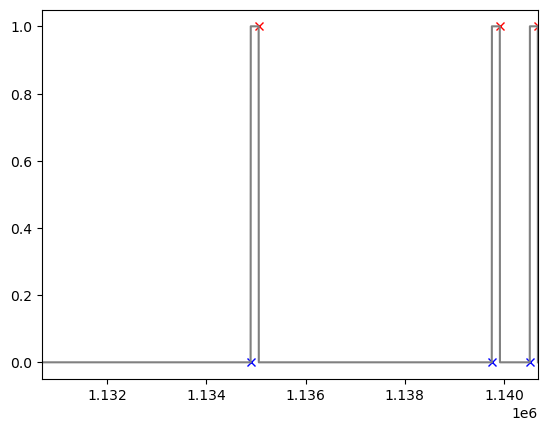

In [39]:
postsleep_cam_ts = cam_ts[cam_ts.epoch == 'postsleep'].reset_index()

### find camera triggers: 

Camera_trig_states = postsleep_cam_ts['Trigger State'].values

where_ttl_changes = list(np.where(np.roll(Camera_trig_states,1)!=Camera_trig_states)[0])
if where_ttl_changes[0] == 0:
    where_ttl_changes = where_ttl_changes[1::]
down_tick = np.array(where_ttl_changes[1::2])
up_tick = np.array(where_ttl_changes[0::2])

## check this is correct:
plt.plot(down_tick,np.ones(len(down_tick)),'x', color = 'red')
plt.plot(up_tick,np.zeros(len(up_tick)),'x',color = 'blue')
plt.plot(Camera_trig_states, color = 'grey')
plt.xlim([max(where_ttl_changes)-10000, max(where_ttl_changes)])


print('blue x should be at uptick - bottom')
print('red should be a downtick - top') 

### set ts variables:
cam_trigger_times = postsleep_cam_ts['Time Stamps'][where_ttl_changes].values
ephys_ts = Bpod_NIDAQ_TTLS['global_timestamp'][postsleep_barcode_index::].values

(-0.5, 0.5)

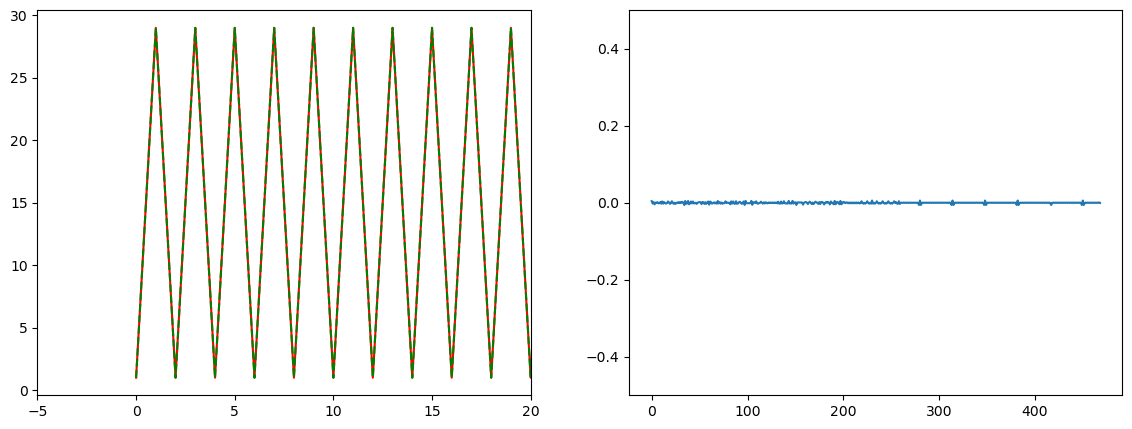

In [40]:
fig, [ax,ax1] = plt.subplots(1, 2, figsize=(14, 5))
ax.plot(np.diff(cam_trigger_times),color = 'red')
ax.plot(np.diff(ephys_ts), '--', color = 'green')
ax.set_xlim([-5, 20])

ax1.plot(np.diff(cam_trigger_times) - np.diff(ephys_ts))
ax1.set_ylim([-0.5, 0.5])

In [41]:
# convert from global timestamps to Probe A/B processor time (as this is what kilosort uses)
# find index in main (NPX spike band) for all events in the recording. Find the smaple index that corresponds with the global timestamp 
# then convert this to relative time for that processor (kilosort time) by dividing sample number by same rate    

## Probe A:
global_ts_in_main_samples = np.searchsorted( main_continuous_global_ts_probeA,ephys_ts)
ephys_times_synced_A = global_ts_in_main_samples/Fs

#Probe B
if ProbeB_exists:
    global_ts_in_main_samples = np.searchsorted( main_continuous_global_ts_probeB,ephys_ts)
    ephys_times_synced_B = global_ts_in_main_samples/Fs
    
###### add things to dataframe
# add new columns
camera_times_s = postsleep_cam_ts['Time Stamps']
postsleep_cam_ts['Camera_time_raw'] = camera_times_s

# add column with camera trigger times 
nan_array = np.array([np.nan]*len(postsleep_cam_ts['Time Stamps'].values))
nan_array[np.array(where_ttl_changes)] = cam_trigger_times
aligned_trigger_times = nan_array
postsleep_cam_ts['Camera_trigger_times'] = aligned_trigger_times

# add column with ephys trigger times for A and B
nan_array_2 = np.array([np.nan]*len(postsleep_cam_ts['Time Stamps'].values))
nan_array_2[np.array(where_ttl_changes)] = ephys_times_synced_A
aligned_trigger_times_ephys = nan_array_2
postsleep_cam_ts['Ephys_trigger_times'] = (aligned_trigger_times_ephys)

if ProbeB_exists:
    nan_array_2 = np.array([np.nan]*len(postsleep_cam_ts['Time Stamps'].values))
    nan_array_2[np.array(where_ttl_changes)] = ephys_times_synced_B
    aligned_trigger_times_ephys = nan_array_2
    postsleep_cam_ts['Ephys_trigger_times_probeB'] = (aligned_trigger_times_ephys)

In [42]:
### align camera time to ephys 
            
aligned_time_A = align_camera_to_ephys_ts(camera_times_s,where_ttl_changes,cam_trigger_times,ephys_times_synced_A)
if ProbeB_exists:
    aligned_time_B = align_camera_to_ephys_ts(camera_times_s,where_ttl_changes,cam_trigger_times,ephys_times_synced_B)
                
                
#### NOT SURE THIS IS THAT USEFUL RIGHT NOW    
end_offset = aligned_time_A[-1] - camera_times_s.values[-1]
start_offset =aligned_time_A[0] - camera_times_s.values[0]
print('ephys starts at:                ' +  str(start_offset))
print('aligned end differecne is:      ' +  str(end_offset))
print('difference is                   ' +  str(start_offset - end_offset ))
            
postsleep_cam_ts['Camera_time_Ephys_Aligned'] = aligned_time_A

if ProbeB_exists:
    postsleep_cam_ts['Camera_time_Ephys_Aligned_probeB'] = aligned_time_B

100%|█████████████████████████████████████████████████████████████████████████| 1141153/1141153 [00:05<00:00, 212521.73it/s]


ephys starts at:                12.823013103999983
aligned end differecne is:      12.870488365333586
difference is                   -0.04747526133360225


In [43]:
out_path = '\\'.join(list(Path(organised_ephys_path).parts[0:-1]))
out_path = out_path + r'\behav_sync\\3_post_sleep\\'
print(out_path)
# if directory doesnt exist then make it
if not os.path.isdir(out_path):
    print('making directory')
    os.mkdir(out_path)
    
#### Save it out:
presleep_cam_ts.to_csv(out_path +'/Postsleep_Ephys_Camera_sync.csv')

Z:\\projects\sequence_squad\revision_data\organised_data\animals\seq006_implant1\recording1_15-11-2024\behav_sync\\3_post_sleep\\
making directory


# testing area

In [ ]:


port3_inds = [np.where(new_PortIn_df.Port.values == 3)[0][10], np.where(new_PortIn_df.Port.values == 3)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 3)[0][-5]]
port1_inds = [np.where(new_PortIn_df.Port.values == 1)[0][10], np.where(new_PortIn_df.Port.values == 1)[0][int(new_PortIn_df.Trial_id.values[-1]/2)], np.where(new_PortIn_df.Port.values == 1)[0][-10]]


# Specify the directory
dir_path = r'D:\\camera_test\\'
# Get a list of all files in the directory
files = glob.glob(os.path.join(dir_path, '*'))
# Loop through the files and delete each one
for file in files:
    os.remove(file)
print("All files deleted in the directory:", dir_path)

## create test videos 
avi_files = [f for f in os.listdir(behav_path) if f.endswith('.avi')]
cam_path = behav_path+avi_files[0]

for ind in port1_inds:
    frame_time = back_pokein_times[ind]
    ffmpeg_extract_subclip(cam_path,frame_time - 1,frame_time,targetname=(dir_path +'port1_'+str(ind) + '_back_test.mp4'))
    
for ind in port3_inds:
    frame_time = back_pokein_times[ind]
    ffmpeg_extract_subclip(cam_path,frame_time-1,frame_time,targetname=(dir_path +'port3_'+str(ind) + '_back_test.mp4'))